# Notebook in Section 4.2  - Convolution as a preprocessing technique

In [1]:
from msc_thesis.datasets import get_toy_dataset
from msc_thesis.convolution import build_noncentral_filter_weights, get_smoothed_dataset, remove_spatial_margins
from msc_thesis.nmf_algorithm import runNMF
from msc_thesis.estimators import get_mse_and_mprime_vs_alpha
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Generate the dataset

In [2]:
# 'No war' datatset parameters
L = 200             # Number of energy channels  
n_poisson = 300     # Average poisson number per pixel (this number will be splitted on the L dimension)
C = 15
P1, P2 = 100,100    # Spatial dimensions
P = P1*P2           # Number of pixels

# Generate synthetic 'experimenta' dataset
G, Wtilde, Dtilde, Htilde_vol, Htilde, Ytilde, Y_vol, Y, K = get_toy_dataset(L, C, n_poisson, seed=1)

## Build the convolution filter (with noncentral weights)

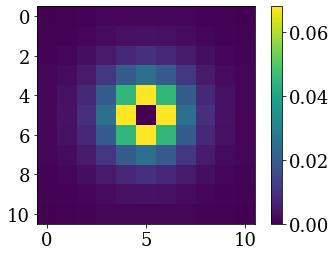

In [3]:
# Obtain noncentral weights (using quadratic programming)
noncentral_weights = build_noncentral_filter_weights(Y_vol, N_rows=100000, size_filter=(1,11,11), isFake=True)[0]

# Plot the filter
plt.imshow(noncentral_weights[:,:])
plt.colorbar()
plt.show()



## Run NMF using different values of $\alpha$

It 10 / 100: loss 0.000,  12.916 it/s
It 20 / 100: loss 0.000,  15.872 it/s
It 30 / 100: loss 0.000,  16.541 it/s
It 40 / 100: loss 0.000,  15.761 it/s
It 50 / 100: loss 0.000,  15.709 it/s
It 60 / 100: loss 0.000,  15.270 it/s
It 70 / 100: loss 0.000,  15.149 it/s
exits because of relative change < tol: 0.0002754797237968312
Stopped after 73 iterations in 0.0 minutes and 5.0 seconds.
;....................................
It 10 / 100: loss 0.000,  13.788 it/s
It 20 / 100: loss 0.000,  14.196 it/s
It 30 / 100: loss 0.000,  16.930 it/s
It 40 / 100: loss 0.000,  19.138 it/s
It 50 / 100: loss 0.000,  20.844 it/s
It 60 / 100: loss 0.000,  22.138 it/s
exits because of relative change < tol: 0.00026750064031807867
Stopped after 68 iterations in 0.0 minutes and 3.0 seconds.
;....................................
It 10 / 100: loss 0.000,  29.603 it/s
It 20 / 100: loss 0.000,  24.320 it/s
It 30 / 100: loss 0.000,  17.598 it/s
It 40 / 100: loss 0.000,  16.022 it/s
It 50 / 100: loss 0.000,  15.005 

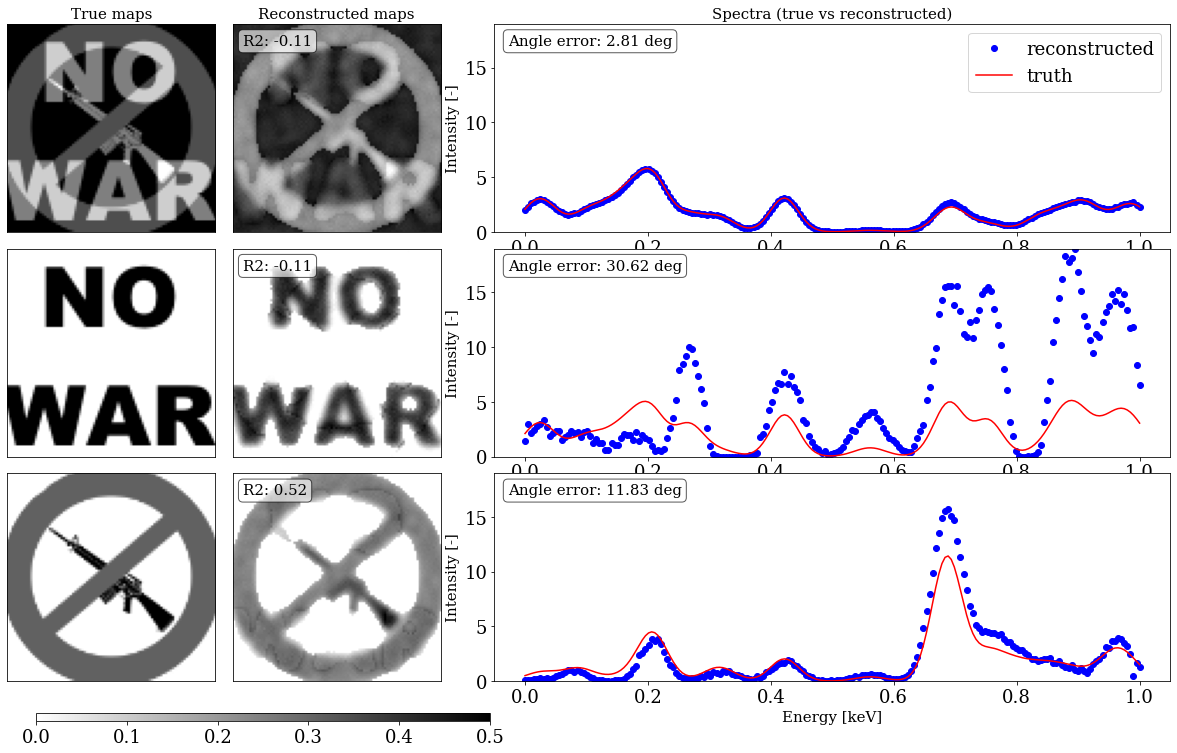

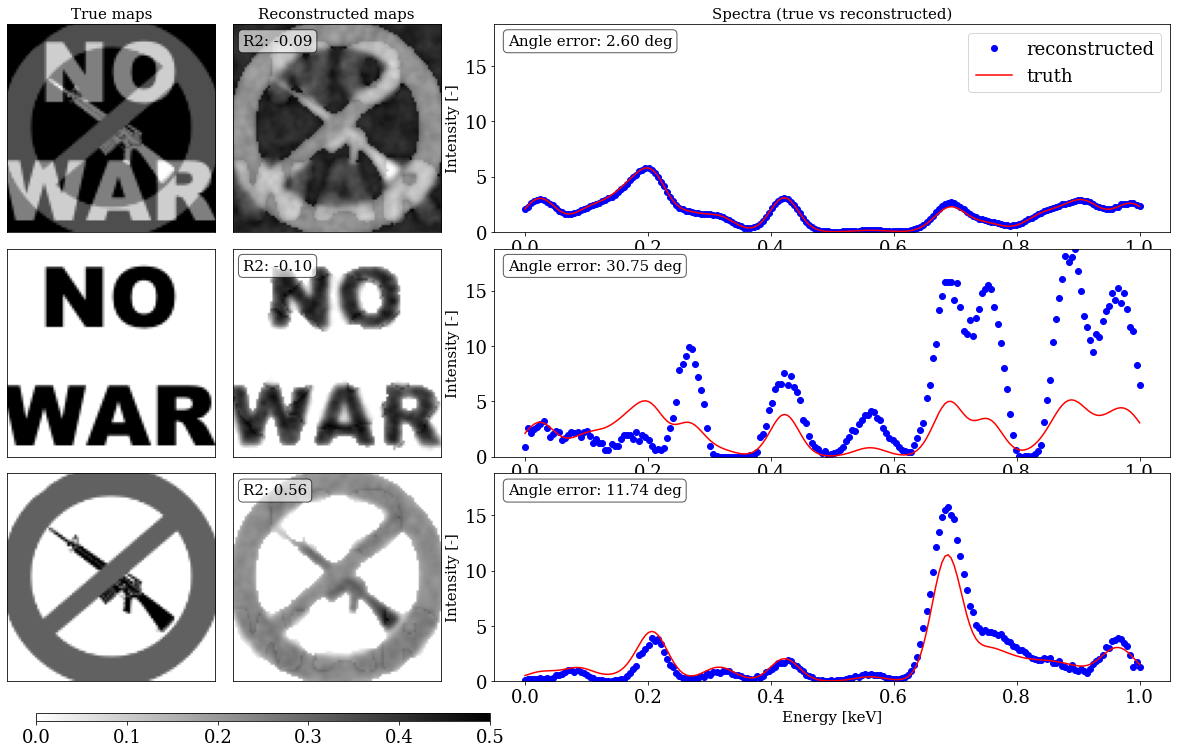

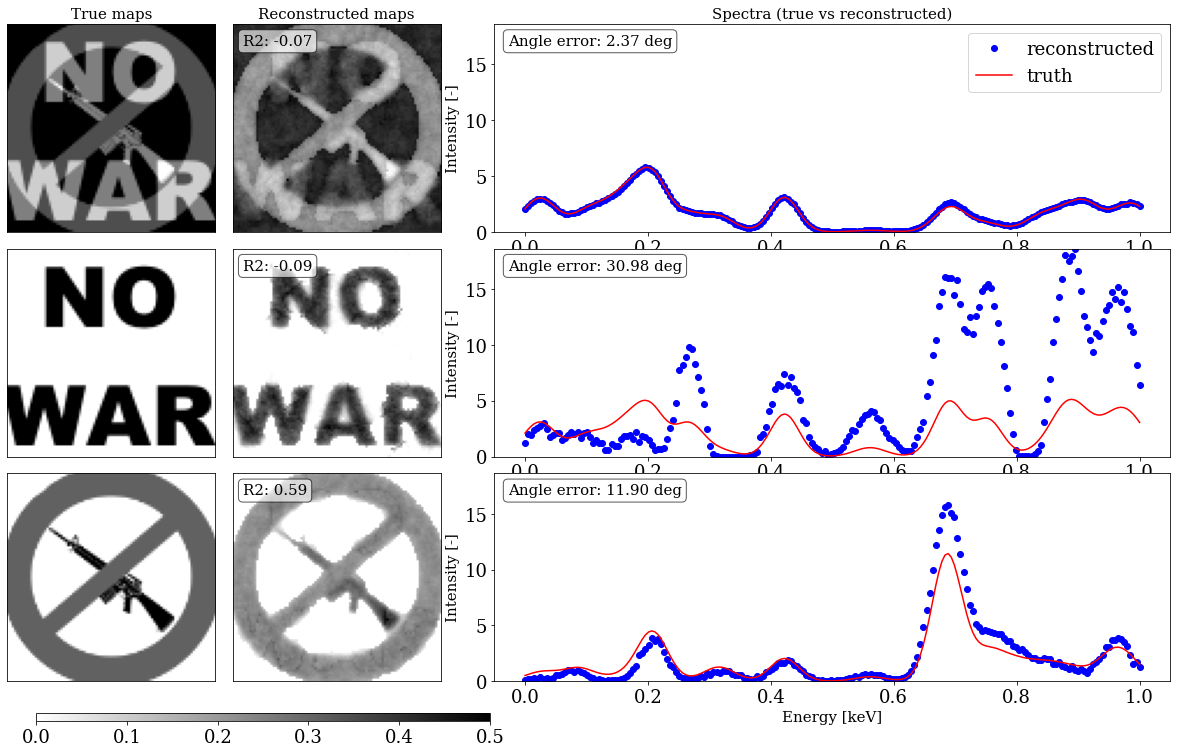

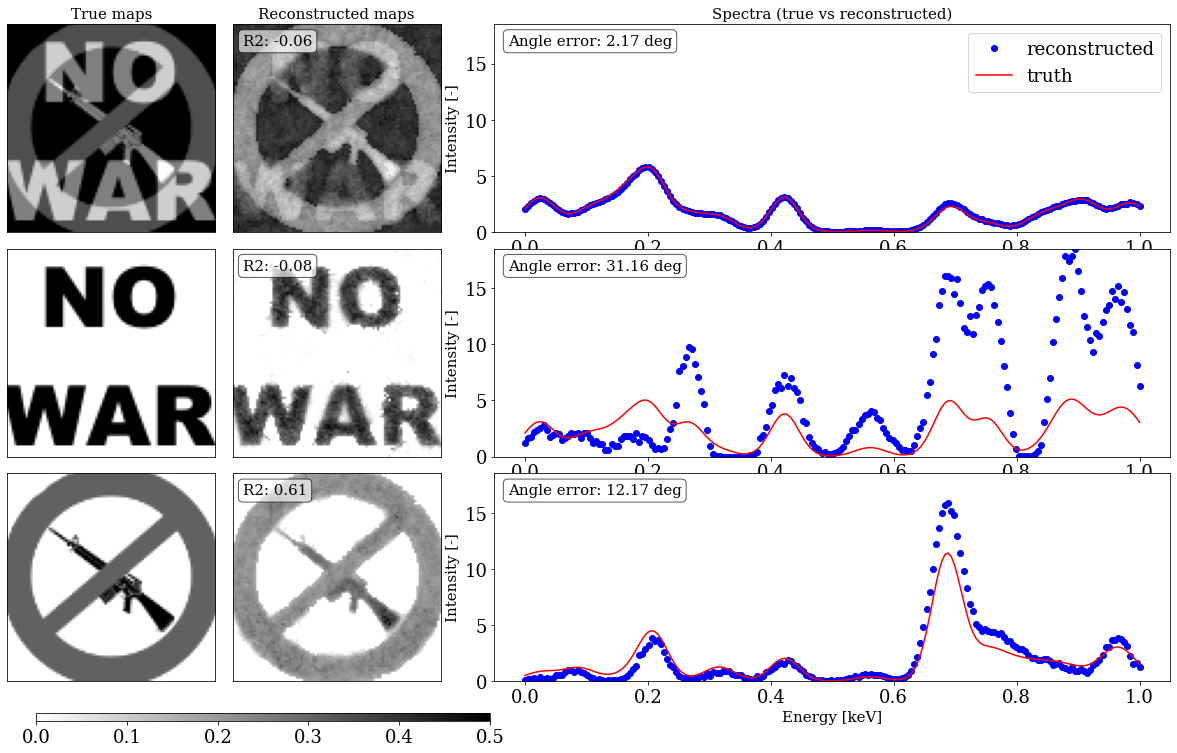

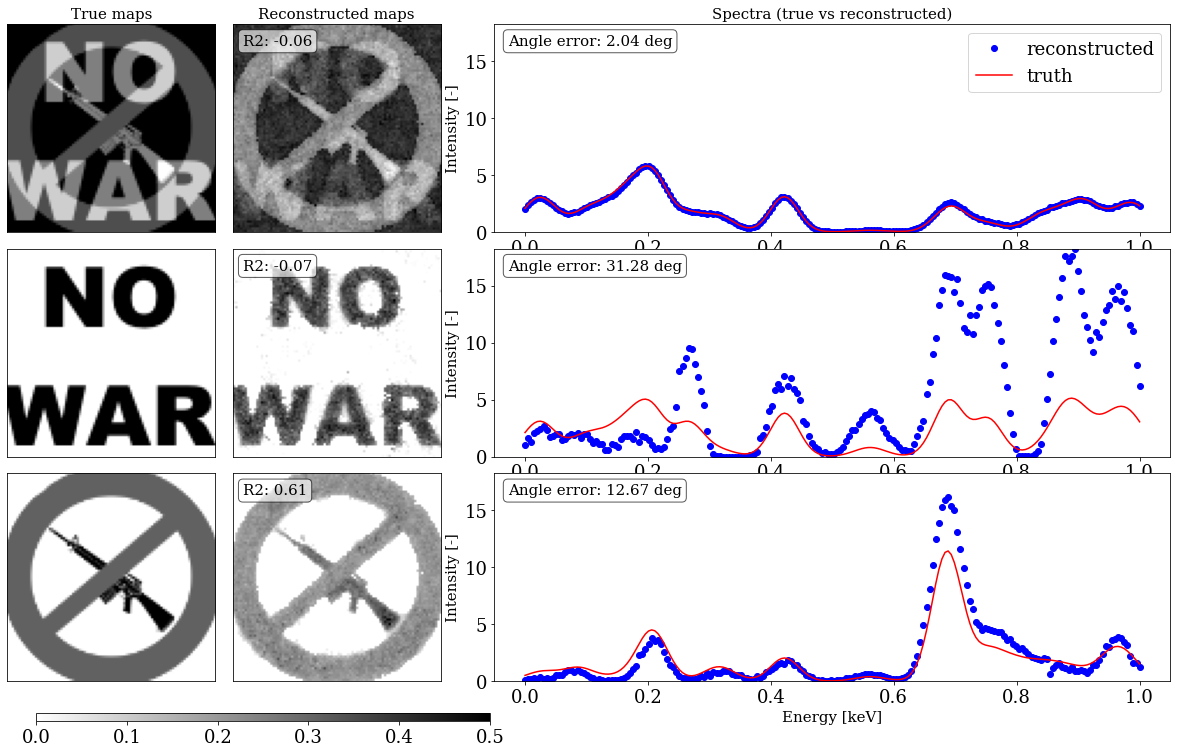

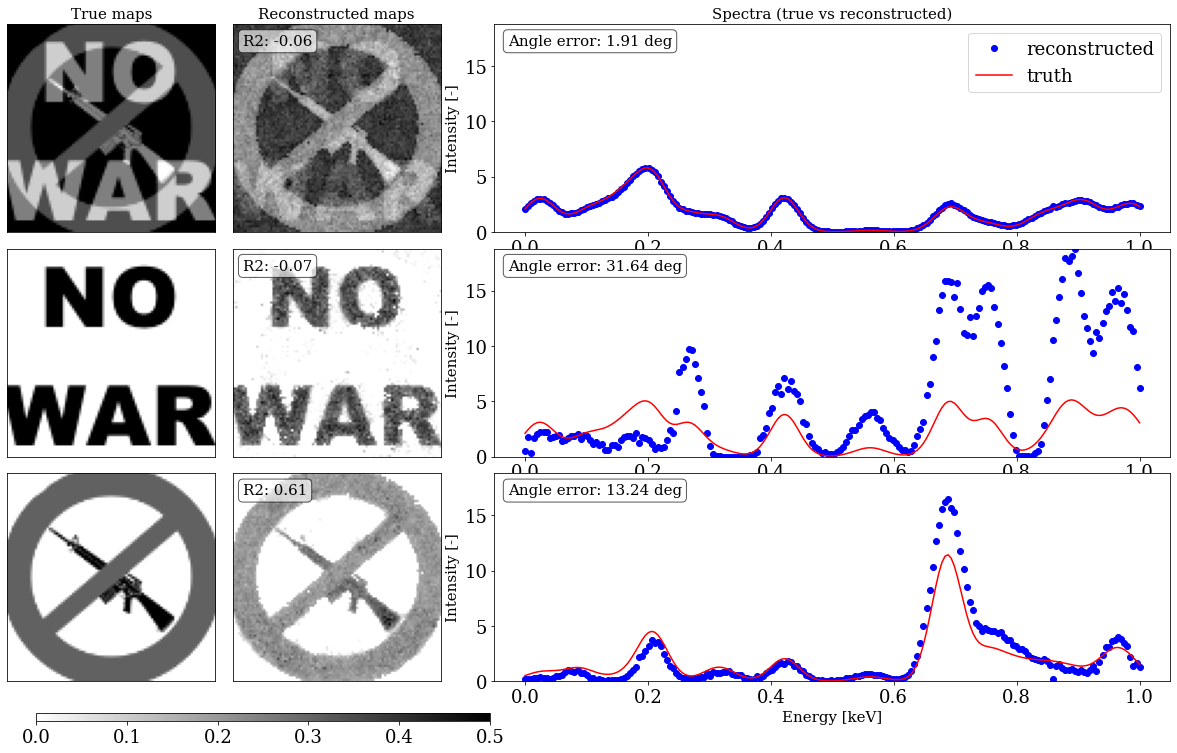

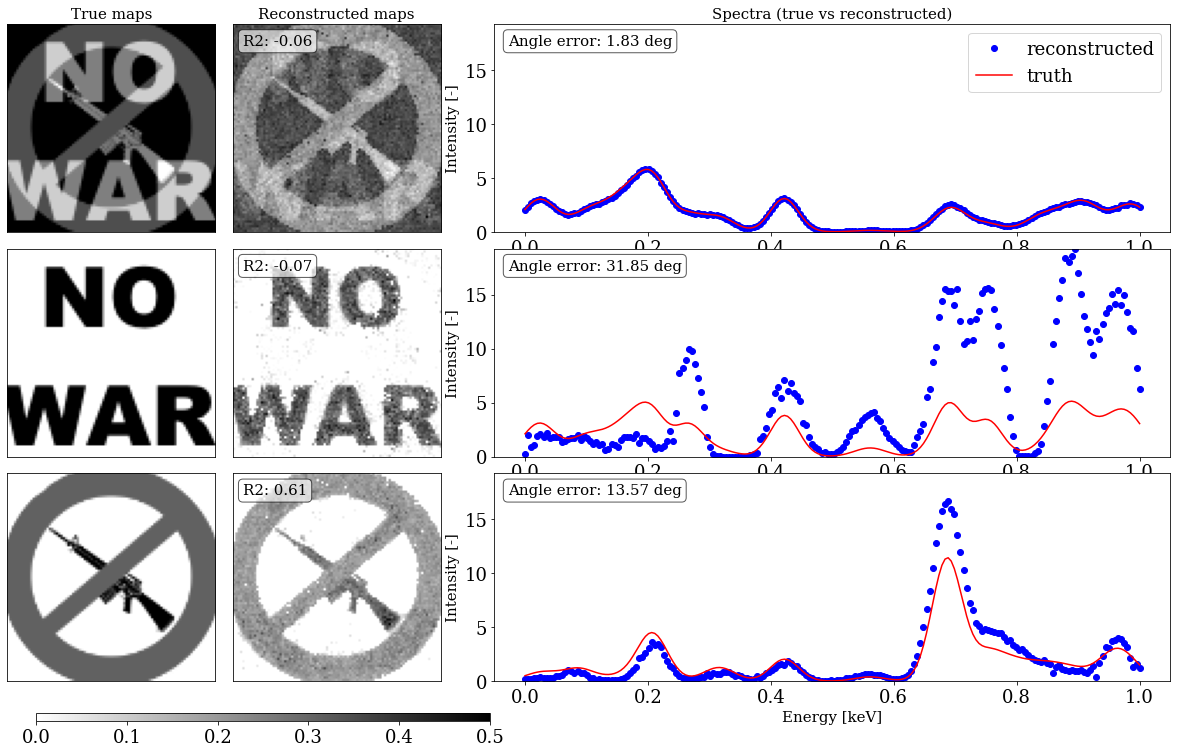

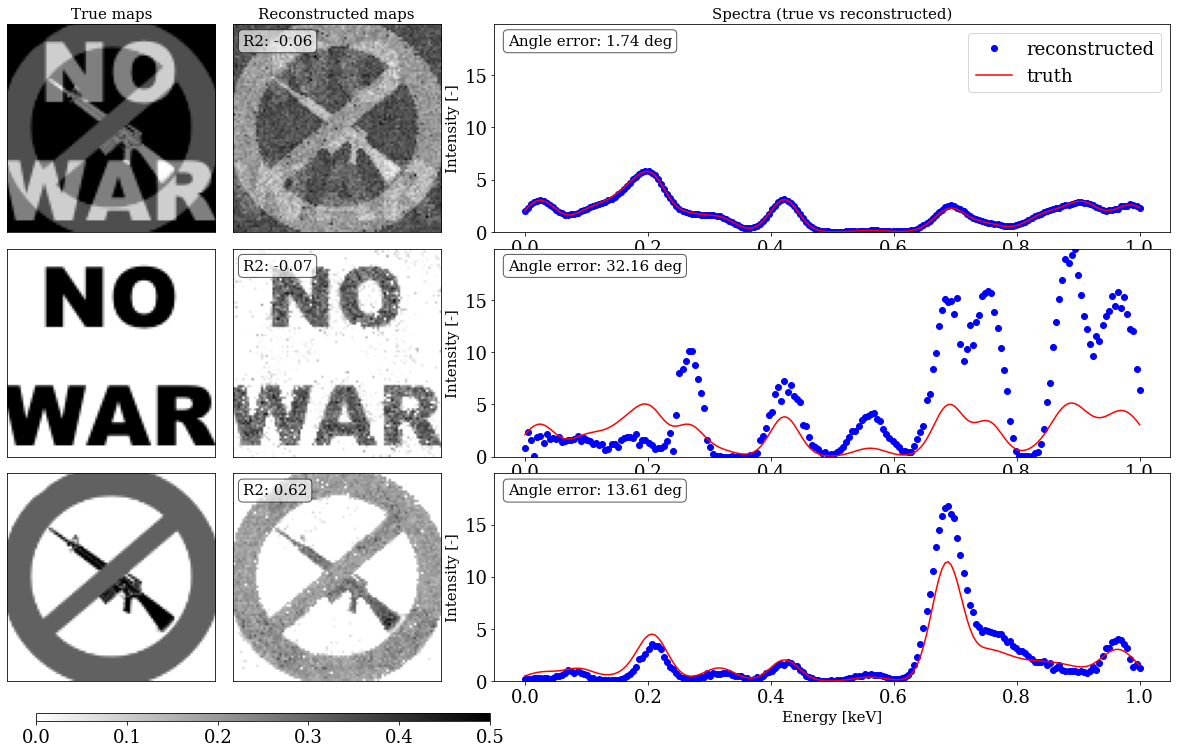

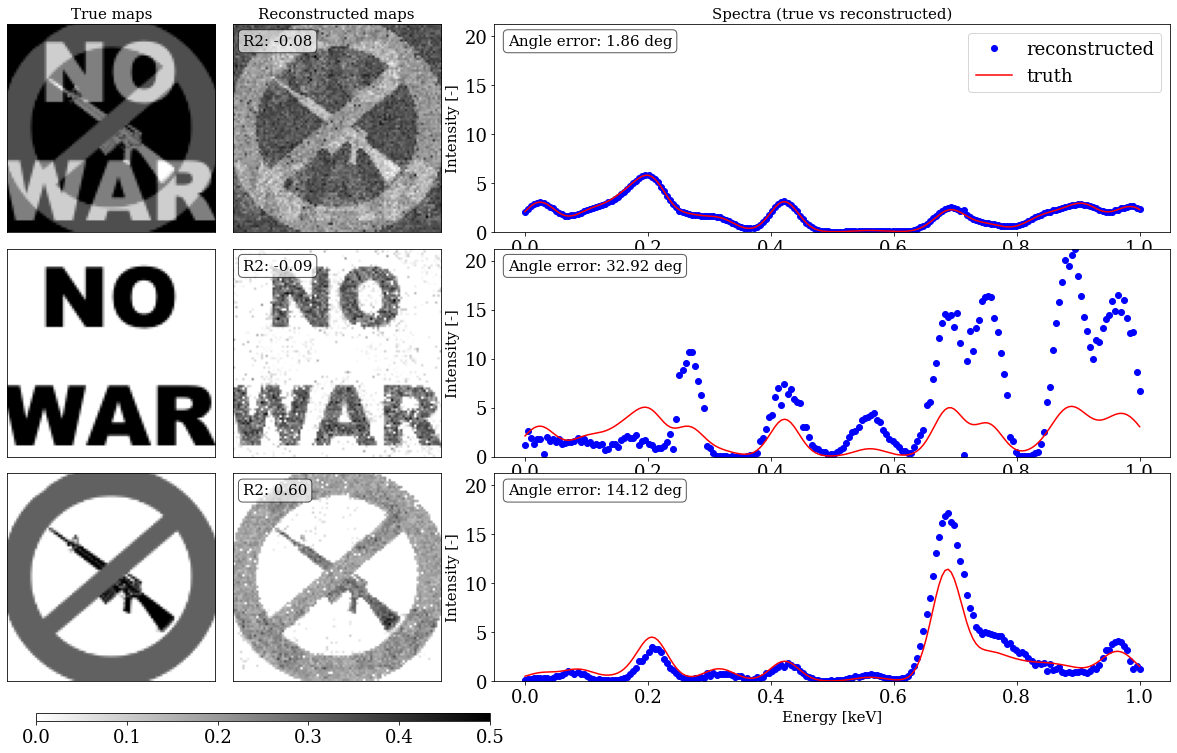

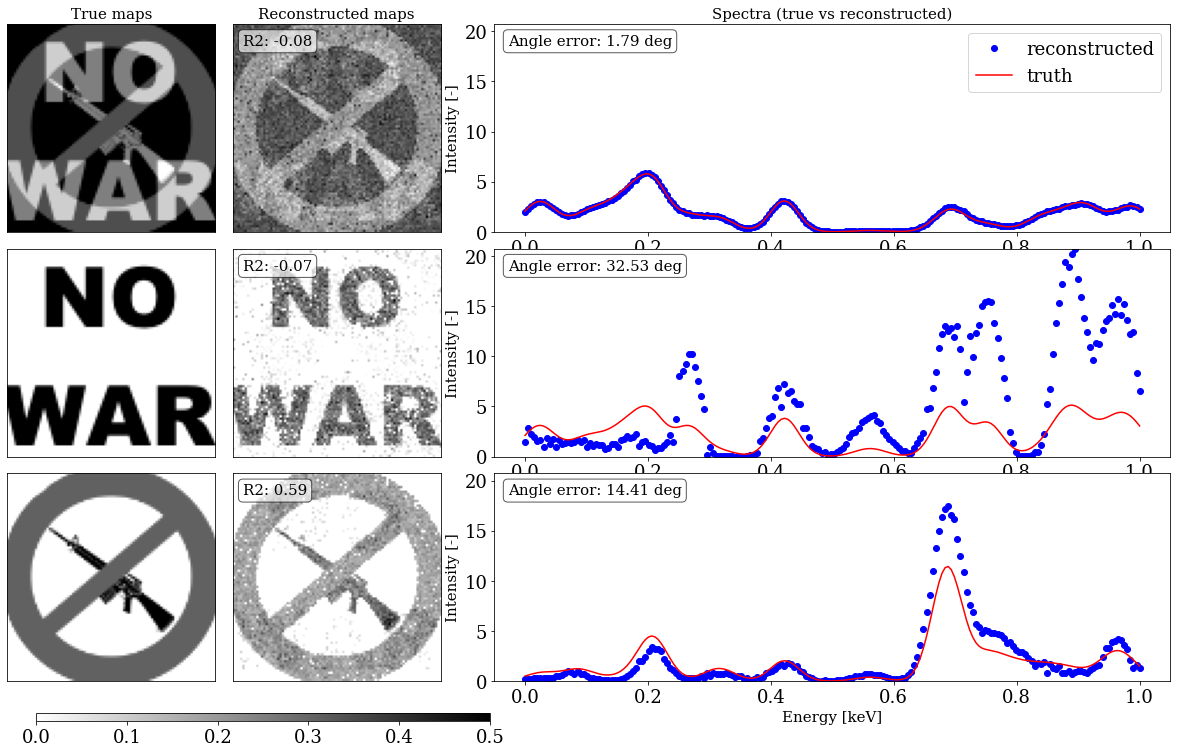

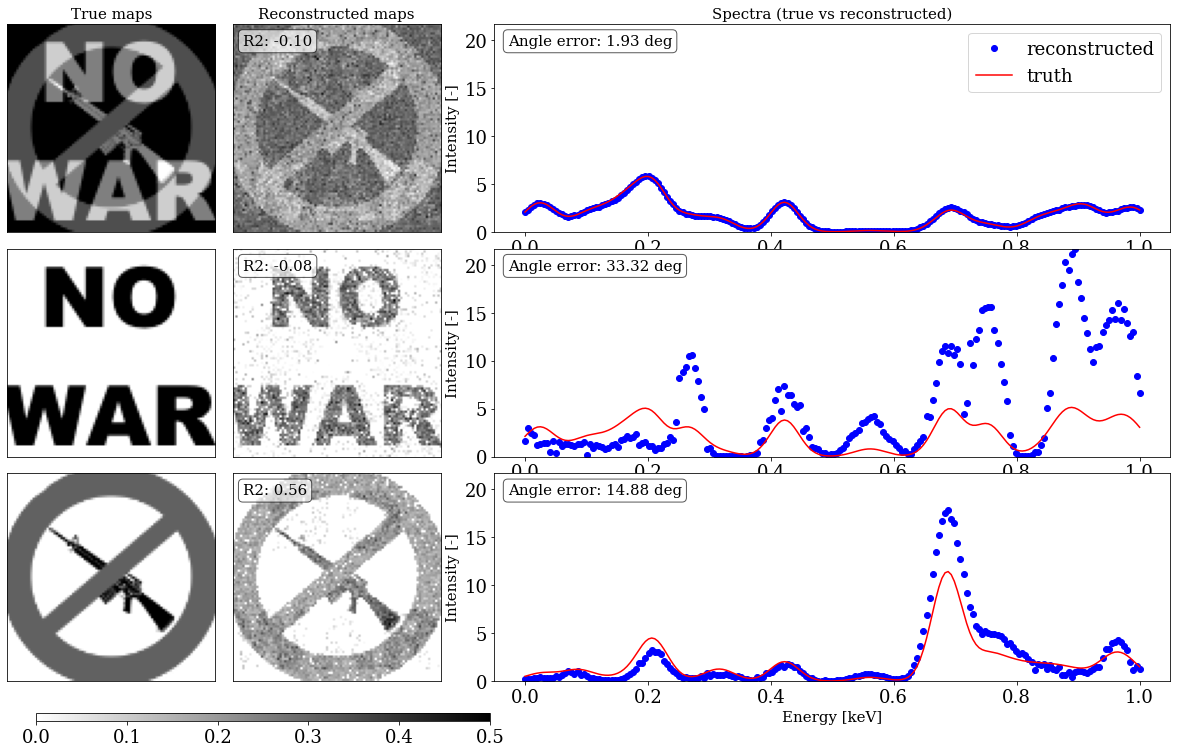

In [4]:
N_iterations = 100          # Set Number of iterations to 100 to obtain similar results as in report

# Convolve Y_vol with filter of noncentral weights to obtain Y_n (see report)
Y_n_vol = get_smoothed_dataset(Y_vol, noncentral_weights)

# Crop margins to disregard voxels for which complete set of neighbours does not exist
Y_vol_crop = remove_spatial_margins(Y_vol, noncentral_weights.shape)
Y_n_vol_crop = remove_spatial_margins(Y_n_vol, noncentral_weights.shape)
H_tilde_vol_crop = remove_spatial_margins(Htilde_vol, noncentral_weights.shape)

resultsconvolution = []                 # To store results
alphas = np.linspace(0,1,11)            # Domain of alpha ranges from 0 to 1 with 0.1 increments
for alpha in alphas:
    # Run NMF and save experiment results
    nmf_run = runNMF(Dtilde, H_tilde_vol_crop.reshape(K,-1), 0,0, [(1,1,1)], alpha, N_iterations, 0, Y_vol_crop, Y_n_vol_crop, None)

    # Store result
    resultsconvolution.append(nmf_run)

# Restructure results for better access
resultsconvolution = list(zip(*resultsconvolution))
angles_convolution, r2s_convolution, times_convolution, mses_convolution, kls_convolution = resultsconvolution[0], resultsconvolution[1], resultsconvolution[2], resultsconvolution[3], resultsconvolution[4]



## Plots Figure 25
Mean squared error and generalized Kullback-Leibler divergence as a function of α
using the ‘no war’ dataset.

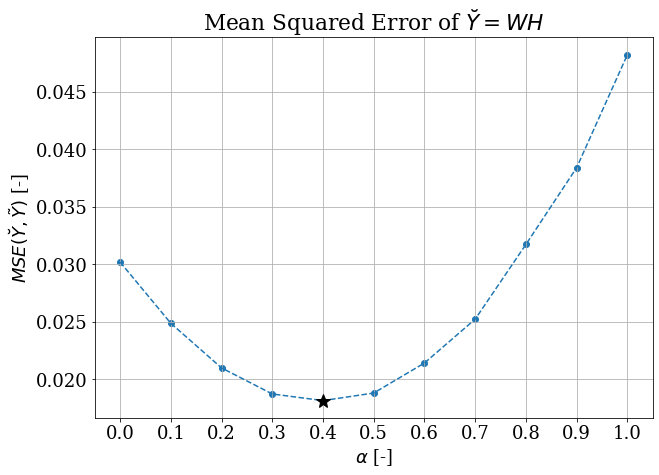

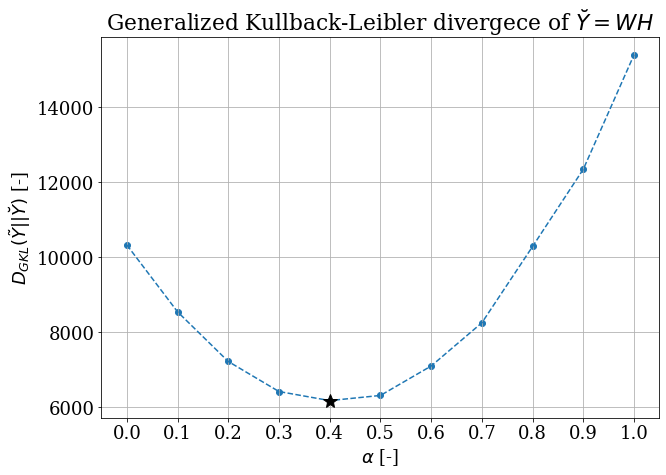

In [5]:
# Plot Figure 25.a
fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(alphas, mses_convolution, linestyle='dashed')
ax1.scatter(alphas, mses_convolution)
min_est  =np.argmin(mses_convolution)
ax1.set_xlabel(r'$\alpha$'+' [-]')
ax1.plot([alphas[min_est]], [mses_convolution[min_est]] , 'k*', markersize=15)
ax1.set_xticks(np.array(alphas))
ax1.grid('on')
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
ax1.set_xlabel(r'$\alpha$'+' [-]')
ax1.set_ylabel(r'$MSE(\breve{Y}, \tilde{Y})$ [-]')
plt.title('Mean Squared Error of '+r'$\breve{Y} = WH$')
plt.show()

# Plot Figure 25.b
fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(alphas, kls_convolution, linestyle='dashed')
ax1.scatter(alphas, kls_convolution)
min_est  =np.argmin(kls_convolution)
ax1.set_xlabel('Binning Factor $B$ [-]')
ax1.plot([alphas[min_est]], [kls_convolution[min_est]] , 'k*', markersize=15)
ax1.set_xticks(alphas)
ax1.grid('on')
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
ax1.set_xlabel(r'$\alpha$'+' [-]')
ax1.set_ylabel(r'$D_{GKL}(\tilde{Y} || \breve{Y})$ [-]')
plt.title('Generalized Kullback-Leibler divergece of '+r'$\breve{Y} = WH$')
plt.show()

## Plots Figure 26 
Average true and estimated MSE and M′ of the ‘no war’ dataset across all voxels as
a function of α. Blue is used to denote the squared bias term, green is used to denote the variance term,
and red is used to denote the MSE for (a) and M′
for (b). Dashed lines represent the estimated values,
whereas the solid lines represent the true values.

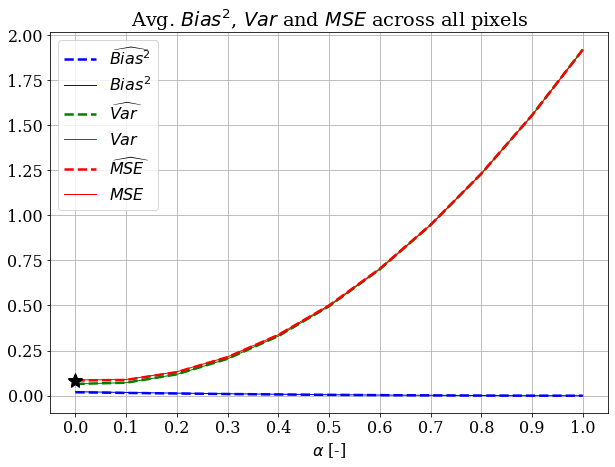

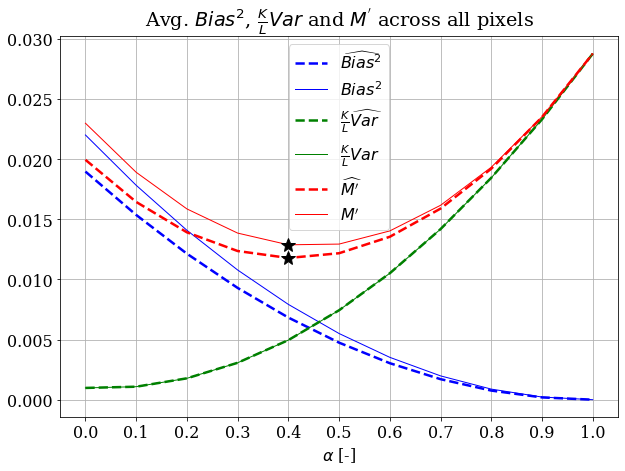

In [6]:
biases_est, biases, vars_est, vars, mses_est, mses, mprimes_est, mprimes = get_mse_and_mprime_vs_alpha(Ytilde, Y_vol, noncentral_weights, alphas, K)

# Plot Figure 26.a
plt.rcParams.update({'font.family':'serif'})
plt.rcParams.update({'font.size': 16})
fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(alphas, biases_est, 'b',linestyle='dashed', linewidth=2.5)
ax1.plot(alphas, biases, 'b', linewidth=1)
ax1.plot(alphas, vars_est,'g',linestyle='dashed', linewidth=2.5)
ax1.plot(alphas, vars,'g', linewidth=1)
ax1.plot(alphas, mses_est, 'r', linestyle='dashed', linewidth=2.5)
ax1.plot(alphas, mses, 'r', linewidth=1)
min_est  =np.argmin(mses_est)
min_gt = np.argmin(mses)
ax1.set_xlabel(r'$\alpha$ [-]')
plt.legend(labels=[r'$\widehat{Bias}^2$',r'$Bias^2$', r'$\widehat{Var}$', '$Var$', r'$\widehat{MSE}$',  '$MSE$'])
ax1.plot([alphas[min_est]], [mses_est[min_est]], 'k*', markersize=15)
ax1.plot([alphas[min_gt]], [mses[min_est]], 'k*', markersize=15)
ax1.grid('on')
ax1.set_xticks([0.1*i for i in range(11)])
plt.title('Avg. '+'$Bias^2$, '+ r'$Var$'+' and $MSE$'+' across all pixels')
plt.show()

# Plot figure 26.b
fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(alphas, biases_est, 'b',linestyle='dashed', linewidth=2.5)
ax1.plot(alphas, biases, 'b', linewidth=1)
ax1.plot(alphas, vars_est*K/L,'g',linestyle='dashed', linewidth=2.5)
ax1.plot(alphas, vars*K/L,'g', linewidth=1)
ax1.plot(alphas, mprimes_est, 'r', linestyle='dashed', linewidth=2.5)
ax1.plot(alphas, mprimes, 'r', linewidth=1)
min_est  =np.argmin(mprimes_est)
min_gt = np.argmin(mprimes)
ax1.set_xlabel(r'$\alpha$ [-]')
plt.legend(labels=[r'$\widehat{Bias}^2$',r'$Bias^2$', r'$\frac{K}{L}\widehat{Var}$', r'$\frac{K}{L}Var$', r'$\widehat{M^{\prime}}$',  r'$M^{\prime}$'])
ax1.plot([alphas[min_est]], [mprimes_est[min_est]], 'k*', markersize=15)
ax1.plot([alphas[min_gt]], [mprimes[min_est]], 'k*', markersize=15)
ax1.set_xticks([0.1*i for i in range(11)])
ax1.grid('on')
plt.title('Avg. '+'$Bias^2$, '+ r'$\frac{K}{L}Var$'+' and $M^{\'}$'+' across all pixels')
plt.show()